In [1]:
import os
import time
import random
import math

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.distributions.binomial import Binomial
from torch.distributions.bernoulli import Bernoulli
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 

from transformers import DataCollatorForLanguageModeling, BertForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, AdamW

from tokens import WordLevelBertTokenizer
from vocab import create_vocab
from data import CausalBertDataset, MLMDataset
from causal_bert import CausalBOW, CausalBert, load_data, true_casual_effect, est_casual_effect

In [2]:
def true_casual_effect(data_loader, effect='ate', estimation='q'):
    assert estimation == 'q', f'unallowed estimation: {estimation}'
    
    dataset = data_loader.dataset
    
    Q1 = dataset.treatment * dataset.response + (1 - dataset.treatment) * dataset.pseudo_response
    Q1 = Q1.cpu().data.numpy().squeeze()

    Q0 = dataset.treatment * dataset.pseudo_response + (1 - dataset.treatment) * dataset.response
    Q0 = Q0.cpu().data.numpy().squeeze()

    treatment = dataset.treatment.cpu().data.numpy().squeeze()
    prop_scores = dataset.prop_scores.cpu().data.numpy().squeeze()
    
    if estimation == 'q':
        if effect == 'att':
            phi = (treatment * (Q1 - Q0))
            return phi.sum() / treatment.sum()
        elif effect == 'ate':
            return (Q1 - Q0).mean()
        
    elif estimation == 'plugin':
        phi = (prop_scores * (Q1 - Q0)).mean()
        if effect == 'att':
            return phi / treatment.mean()
        elif effect == 'ate': 
            return phi

In [3]:
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[{alpha}-{beta}]_C-{args,model,upper()}_{args,hidden_size}_{args,epoch}.pth'
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[BEST]_[0,25-1,0]_C-BERT_64_22.pth'
trained = '/nfs/turbo/lsa-regier/bert-results/results/casualmodel/[BEST]_[0,5-5,0]_C-BERT_64_22.pth'

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
model = torch.load(trained).to(device)

In [5]:
alpha = 0.5
beta = 5.
offset_t = 0
offset_p = 0.2

train, test = load_data(alpha, beta, offset_t, offset_p, 16, device=device)

Load training set in 63.09 sec
Training set: [treated: 0.2375], [prop scores counts: 0.0626]
Load validation set in 59.59 sec
Testing set: [treated: 0.2381], [prop scores counts: 0.0635]
****************************************************************************************************


In [7]:
prop_scores = []

treatments = []
responses = []
real_prop_scores = []

tokens = []
model.eval()
for idx, (token, treatment, response, real_prop_score) in enumerate(test):
    prop_score, _, _ = model(token)
    if model.prop_is_logit:
        sigmoid = nn.Sigmoid()
        prop_score = sigmoid(prop_score)
    prop_scores.append(prop_score.cpu().data.numpy().squeeze())
    treatments.append(treatment.cpu().data.numpy().squeeze())
    responses.append(response.cpu().data.numpy().squeeze())
    real_prop_scores.append(real_prop_score.cpu().data.numpy().squeeze())
    tokens.append(token.cpu().data.numpy().squeeze())
    
prop_scores = np.concatenate(prop_scores, axis=0)
treatments = np.concatenate(treatments, axis=0)
responses = np.concatenate(responses, axis=0)
real_prop_scores = np.concatenate(real_prop_scores, axis=0)
tokens = np.concatenate(tokens, axis=0)

Text(0, 0.5, 'Predicted propensity scores')

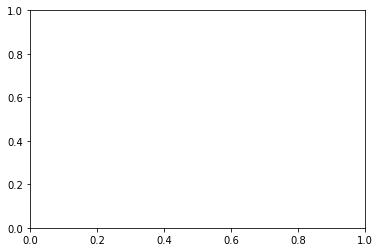

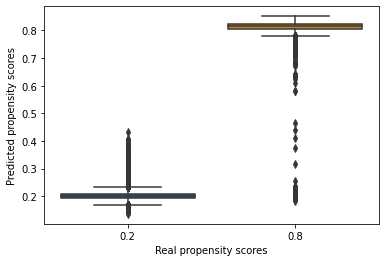

In [8]:
dat = np.array([real_prop_scores, prop_scores]).T
dat = pd.DataFrame(dat, columns=['real_prop_scores', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='real_prop_scores', data=dat, palette="colorblind", )
ax.set_xlabel('Real propensity scores')
ax.set_ylabel('Predicted propensity scores')

In [11]:
real_att_q = true_casual_effect(test, 'att')
print(f'real ATT: {real_att_q:.4f}')

real ATT: 0.1030


In [9]:
# real prop score
t1 = responses[treatments == 1].mean()

w = real_prop_scores / (1 - real_prop_scores)
t0 = (w[treatments == 0] * responses[treatments == 0]).sum() / (w[treatments == 0]).sum()

t1 - t0

0.100123465

In [10]:
# est prop score
t1 = responses[treatments == 1].mean()

w = prop_scores / (1 - prop_scores)
t0 = (w[treatments == 0] * responses[treatments == 0]).sum() / (w[treatments == 0]).sum()

t1 - t0

0.09341961

In [32]:
outliers = tokens[abs(prop_scores - real_prop_scores) > 0.3]

In [49]:
dat_pred = np.concatenate([tokens, prop_scores[:, np.newaxis], real_prop_scores[:, np.newaxis]], axis=1)

In [38]:
dat_pred = np.array(tokens, prop_scores, real_prop_scores)

dat = np.array([real_prop_scores, prop_scores]).T
dat = pd.DataFrame(dat, columns=['real_prop_scores', 'pred_prop_scores'])


(30, 512)

In [7]:
vocab = create_vocab(merged=True, uni_diag=True)
tokenizer = WordLevelBertTokenizer(vocab)

In [27]:
tokenizer

In [88]:
bug_influent = 0
for i in range(tokens.shape[0]):
    raw_seq = tokenizer.decode(tokens[i])
    if 'diag:J45' not in raw_seq:
        if abs(real_prop_scores[i] - 0.8) < 0.1:
            bug_influent += 1

In [90]:
bug_influent

16

In [87]:
i

191759

In [95]:
len(special)

819

In [96]:
# special = []
# real_p = []
# p = []
# for i in range(tokens.shape[0]):
#     if abs(prop_scores[i] - real_prop_scores[i]) > 0.1:
#         raw_seq = tokenizer.decode(tokens[i])
        
#         print(f'[real: {real_prop_scores[i]:.2f}] - [predict: {prop_scores[i]:.4f}]')
#         print(raw_seq)
#         if 'diag:J45' not in raw_seq and abs(real_prop_scores[i] - 0.8) < 0.1:
#             print('find bug')
# #             break
#         print('-' * 300)
        
#         special.append(raw_seq)
#         real_p.append(round(real_prop_scores[i], 2))
#         p.append(round(prop_scores[i], 2))

# print('finish')

In [98]:
r = responses[abs(prop_scores - real_prop_scores) < 0.1]
t = treatments[abs(prop_scores - real_prop_scores) < 0.1]
p = prop_scores[abs(prop_scores - real_prop_scores) < 0.1]

t1 = r[t == 1].mean()

w = p / (1 - p)
t0 = (w[t == 0] * r[t == 0]).sum() / (w[t == 0]).sum()

t1 - t0

0.122840226

In [102]:
r = np.concatenate([responses[abs(prop_scores - real_prop_scores) < 1], responses[abs(prop_scores - real_prop_scores) >= 1]], axis=0)
t = np.concatenate([treatments[abs(prop_scores - real_prop_scores) < 1], treatments[abs(prop_scores - real_prop_scores) >= 1]], axis=0)
p = np.concatenate([prop_scores[abs(prop_scores - real_prop_scores) < 1], real_prop_scores[abs(prop_scores - real_prop_scores) >= 1]], axis=0)

t1 = r[t == 1].mean()

w = p / (1 - p)
t0 = (w[t == 0] * r[t == 0]).sum() / (w[t == 0]).sum()

t1 - t0

0.12355143

In [106]:
print(f'Real: [0.8], Est: [{prop_scores[real_prop_scores > 0.5].mean():.4f}({prop_scores[real_prop_scores > 0.5].std():.4f})]')
print(f'Real: [0.2], Est: [{prop_scores[real_prop_scores < 0.5].mean():.4f}({prop_scores[real_prop_scores < 0.5].std():.4f})]')


Real: [0.8], Est: [0.8068(0.0307)]
Real: [0.8], Est: [0.1870(0.0319)]


0.13526529

Text(0, 0.5, 'Predicted propensity scores')

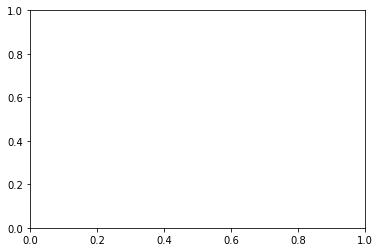

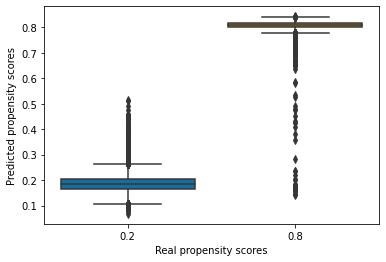

In [9]:
dat = np.array([real_prop_scores, prop_scores]).T
dat = pd.DataFrame(dat, columns=['real_prop_scores', 'pred_prop_scores'])

plt.cla()
fig = plt.figure()
ax = fig.add_subplot(111)
_ = sns.boxplot(y='pred_prop_scores', x='real_prop_scores', data=dat, palette="colorblind", )
ax.set_xlabel('Real propensity scores')
ax.set_ylabel('Predicted propensity scores')

In [10]:
# att_p = est_casual_effect(test, model, 'att', 'q', evaluate=False)[0]
# print(att_p)

In [12]:
att_plugin = est_casual_effect(test, model, 'att', 'plugin', evaluate=False)[0]
print(att_plugin)

KeyboardInterrupt: 

In [11]:
att_plugin = est_casual_effect(test, model, 'att', 'plugin', evaluate=False)[0]
print(att_plugin)

0.10595347


In [ ]:

t1 = responses[treatments == 1].mean()

w = real_prop_scores / (1 - real_prop_scores)
t0 = (w[treatments == 0] * responses[treatments == 0]).sum() / (w[treatments == 0]).sum()

t1 - t0

In [115]:
rs = test.dataset.response
ts = test.dataset.treatment
ps = test.dataset.prop_scores

t1 = rs[ts==1].mean()

w = ps / (1 - ps)

t0 = (w[ts == 0] * rs[ts == 0]).sum() / (w[ts == 0]).sum()
t1 - t0

tensor(0.1353, device='cuda:0')